## answers 05: the adventure of the telltale composition

I only need NumPy and Matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## preliminaries

#### FASTA reading function

I need to read the two genomes from FASTA files (for my training data) and the two FASTA files with sets of 10,000 sequences (for my test data). The genomes are small (about 30K each) and the test sets of 10,000 sequences of length 200 also aren't too big (2 Mb total). I can afford to just pull it into memory without having to do anything fancy. I'll write a `read_fasta()` that reads any number of sequences from a file, stores them in a list, and returns the list. 

For implementing my Markov model, it's going to be convenient to "digitize" these sequences. Instead of leaving the symbols as A|C|G|T, I'll represent the residues as integers 0|1|2|3. Then I can index arrays directly by residue. Even better, I can treat a k-mer as a base-four number, and use a _k-mer_ as an array index directly. GAAT = $ 2 \cdot 4^3 + 0 \cdot 4^2 + 0 \cdot 4^2 + 3 = 131$, for example, with all possible 4-mers having values from $0 \ldots 255$, in alphabetical order AAAA=0 $\ldots$ TTTT=255.

If we have an alphabet `alph = 'ACGT'`, with `A = len(alph)` different symbols, we can encode a letter `a` to digital code `x` with `x = alph.find(a)`. We can decode `x` back to a letter `a` with `a = alph[x]`.

I have to watch out for symbols other than the canonical A,C,G,T. Remember there are ambiguity symbols, such as N for any, Y for pyrimidine (C,T), and R for purine (A,G). Here I'll encode any noncanonical symbols as a flag -1 (which happens to be what `<str>.find(x)` method returns if it doesn't find `x` in the string). Subsequent routines will have to watch out for the -1 flag. None will occur: the training and test data, happily, are all canonical A|C|G|T.

In [2]:
def read_fasta(file, alph):
    """
    Read sequence(s) from <file>, and digitize them according to
    alphabet <alph>.

    A digital sequence is a list, with values 0..A-1, or -1 for invalid
    residue. Values are the index in <alph>: 0=A, 1=C, 2=G, 3=T for 
    'ACGT'.

    Input:
      file : name of FASTA file to read
      alph : alphabet residues; 'ACGT'

    Returns:
      S    : list of digital sequences. len(S) is the number of seqs.
             Each sequence is a list of digital codes. 
             len(S[0]) is the length of the 1st seq in residues, and so on.
    """
    S   = []
    dsq = []
    with open(file) as f:
        for line in f:
            if line.startswith('>'): 
                if len(dsq) > 0:
                    S.append(dsq)
                    dsq = []
            else:
                dsq += [ alph.find(x) for x in line.strip().upper() ]   ## <str>.find() returns -1 if x is not in 'ACGT'
    if len(dsq) > 0:
        S.append(dsq)
    return S

#### Sequence data input

Now I can read the training and test data. I'll refer to the _Streptomyces_ phage and _PapayaSalad_ reference genome as "type 1", and
the _Microbacterium_ phage species and _OscarSo_ reference genome as "type 2". I'll read the genomes into `G1` and `G2`. These will be lists of just one sequence each. Then I'll read the test read data into two sets `R1` and `R2`, which really _are_ lists of sequences. 

I'll also read Moriarty's uniform iid negative control sequences into `Rneg`.

In [3]:
alph = 'ACGT'

G1   = read_fasta('PapayaSalad.fa', alph)
G2   = read_fasta('OscarSo.fa',     alph)

R1   = read_fasta('strep-test.fa',  alph)
R2   = read_fasta('micro-test.fa',  alph)

Rneg = read_fasta('moriarty-neg.fa', alph)

## 1. test Moriarty's method

I'll write a function to implement Moriarty's method.

In [4]:
def moriarty_score(dsq):
    """
    Calculate and return Moriarty's proprietary discrimination score
    for digital sequence <dsq>.
    """
    sigma = [ -1, 1, 1, -1]
    score = 0
    for x in dsq:
        score += sigma[x]
    return score


I can use list comprehensions to compactly score every test sequences, to get two lists of scores `sc1` and `sc2` that I'll use to plot my histogram.

In [5]:
sc1 = [ moriarty_score(dsq) for dsq in R1 ]
sc2 = [ moriarty_score(dsq) for dsq in R2 ]


There's a bunch of ways to do the ROC plot. We're doing it manually here, so we know how it works. I'll create one list of tuples, with element 0 in each tuple being a 1 or 2 to indicate which type of sequence it was, and element 1 in the tuple being the score. Then I'll sort that list from highest to lowest score, then sweep through it counting "true positives" >= each "false positive" in turn. 

I'll make it a function so I can reuse it in part 2, then immediately call it.

In [6]:
def rocplot(sc1, sc2):
    L =      [ (1, sc) for sc in sc1 ]
    L.extend([ (2, sc) for sc in sc2 ])
    L.sort(reverse=True, key=lambda elem:elem[1])    # this idiom with a `lambda` function is useful for sorting lists of tuples

    FP = [ 0 ]
    TP = [ 0 ]
    n1 = 0
    n2 = 0
    for s in L:
        if s[0] == 1: n1 += 1
        else:         
            n2 += 1
            FP.append(n2)
            TP.append(n1)

    # now convert counts to frequencies. nT = number in set 1; nF = number in set 2
    for i in range(n1+1): TP[i] /= n1
    for i in range(n2+1): FP[i] /= n2
    return (TP, FP)

(roc_TP, roc_FP) = rocplot(sc1, sc2)

Now we can plot the histogram and the ROC plot.

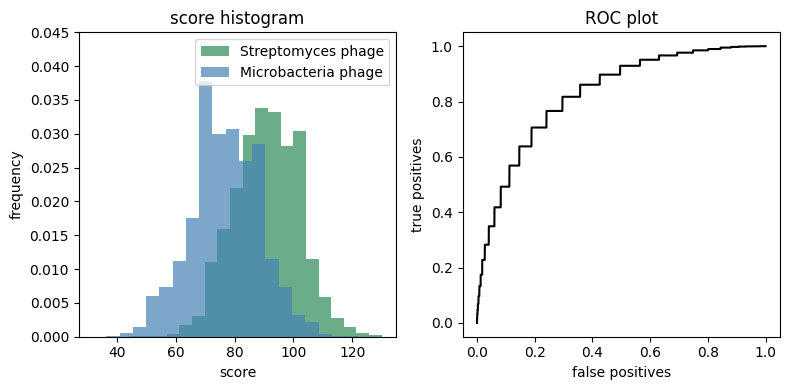

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.hist(sc1, bins=20, density=True, color='seagreen',  label='Streptomyces phage',   alpha=0.7)
ax1.hist(sc2, bins=20, density=True, color='steelblue', label='Microbacteria phage',  alpha=0.7)
ax1.set_title('score histogram')
ax1.set_xlabel('score')
ax1.set_ylabel('frequency')
ax1.set_ylim([0, 0.045])
ax1.legend()

ax2.plot(roc_FP, roc_TP, 'k-')
ax2.set_title('ROC plot')
ax2.set_xlabel('false positives')
ax2.set_ylabel('true positives')

fig.tight_layout()


By giving +1 to a G|C and -1 to a A|T, Moriarty's score is high when G+C composition of the sequence is high. Both types of phage have GC-rich genomes, about 73% for the _Streptomyces_ phage and about 69% GC for the _Microbacteria_ phage. The expected score per position of a 73% GC sequence is 0.46 $(0.73 \cdot 1 + (1-0.73) \cdot -1)$, so the expected score of a L=200 sequence is about 92. For a 69%GC sequence, the expected score of a L=200 read is about 76. 

Meanwhile the expected score for a random iid sequence of uniform 50% GC composition is 0. Moriarty saw perfect discrimination when he compared a phage test set against random iid sequences of uniform composition, because his score is only looking at GC composition. There's a big GC composition difference between the phage reads and 50% GC. But between the two phage types, there's very little difference in just GC composition. Moriarty's method doesn't discriminate the two sets well. 

## 2. make your own method

We're told to make 2nd order Markov models, one for each phage type, and to train each model on a representative genome sequence. 

A second order Markov model has parameters $P(x_i \mid x_{i-1}, x_{i-2})$, where the probability of each residue depends on the two before it. The total log probability of a sequence is $\log P(x_1..x_L) = \log P(x_1,x_2,x_3) \prod_{i=4}^{L} \log P(x_i \mid x_{i-1}, x_{i-2})$.

Note the pesky $P(x_1,x_2,x_3)$ at the start of the chain. There are different ways to handle this initialization. Handling it this way ends up being pretty compact. 

I'll count the joint probability of all 3-mers first (that's my `collect_kmer_probs()` function), then use algebra and marginalization to convert to the conditional Markov probabilities we need (that's my `make_markov()` function). If $P(xyz)$ is the joint probability of a 3-mer $xyz$, then I can get $P(xy) = \sum_z P(xyz)$ by marginalization, then get my second order Markov probabilities as $P(z \mid xy) = \frac{P(xyz)}{P(xy)}$ from the relationship between conditional and joint probabilities.

I've written this in a way that generalizes to any order Markov model, not just 2. To do this, my code talks about the _context_ `c`, the previous residues that my Markov chain depends on, where `c` is a digitized code from $0..4^{K-1}-1$. As I already mentioned above, I treat $x_{i-2}, x_{i-1}$ as a base four number: AA encodes as $0 \times 4 + 0 = 0$, CG encodes as $1 \times 4+2 = 6$, TT encodes as $3 \times 4+3 = 15$. My Markov model is then parameterized as a 2D array $P(x \mid c)$ regardless of what order it is.

In [8]:
def collect_kmer_probs(S, A, K):
    """
    Given an array of digitized seqs <S>, count the <K>-mers in it. Expect
    digitized residues 0..A-1. Return array of normalized K-mer
    frequencies <pk[0..(A**K)-1>.

    Input: 
       S : array of digitized sequences
       A : alphabet size (e.g. 4)
       K : length of K-mers to count, int; (e.g. 3)

    Returns:
       pk   : frequencies of each encoded kmer, pk[0..A**K-1]
    """

    Nk    = A**K         # number of possible k-mers
    pk    = np.zeros(Nk) # pk[kmer] : count of each encoded kmer
    for dsq in S:
        ngood, kmer = 0,0                        # reset kmer for new sequence
        for x in dsq:
            if x != -1:                          # if x_i is a good ACGT residue...
                kmer   = ((kmer * A) % Nk) + x   #  ... update kmer code
                ngood += 1                       #  ... bump # of residues since last bad one.
                if ngood >= K:                   # if we've seen at least K good residues...
                    pk[kmer] += 1                #  ... bump kmer count.
            else:
                ngood, kmer = 0,0

    Z  = np.sum(pk)         # normalize counts to probabilities
    pk = np.divide(pk, Z)
    return pk


In [9]:
def make_markov(pk, A, K):
    """
    Given joint <K>-mer frequencies <pk[]>, calculate Markov
    conditional probabilities P(x|y) for one residue x
    and encoded context of K-1 previous residues.

    Input:
      pk   : frequencies of each (encoded) kmer, pk[0..A**K-1]
      A    : alphabet size (e.g. 4)
      K    : length of K-mers in <pk>, int (e.g. 3)

    Return:
     mp : P(x | c), conditional Markov chain probabilities      
    """
    Nc = A**(K-1)
    mp = pk.reshape( Nc, A )   # now Nc rows x A columns: each row is a prob vector for one context. 
    for c in range(Nc):
        Z = np.sum(mp[c])
        mp[c] = np.divide(mp[c], Z)
    return mp


I'm going to need a little routine for encoding a subsequence to my context code $c$:

In [10]:
def encode(dsq, A, K):
    c  = 0
    for i in range(len(dsq)):
        c = c * A + dsq[i]
    return c


Now for the routine to calculate the log probability of a read, given the conditional Markov probabilities in `mp`, plus the joint k-mer probabilities in `pk` that I only need for initializing the chain.

I update my context `c` one nucleotide at a time, using modulo division to remove the old nucleotide from the front, then add the new nucleotide 0..3 to the back. I want my routine to generalize to the case of K=1 (iid sequences, 0th order Markov model), where the context length is 0; I have to be careful that my context `c` is always 0 in the K=1 case.

In [11]:
def logp_markov(dsq, pk, mp, A, K):
    """Returns log P(seq | model). 

    pk are the joint probabilities of each k-mer of length K; we need these to initialize the Markov chain.
    mp are the conditional Markov probabilities P(x | y) for one residue x given K-1 previous residues 
    """
    Nc   = A**(K-1)
    c    = encode(dsq[:K], A, K)     # first k-mer
    logp = np.log(pk[c])             # initialize log prob by generating first K residues from joint probs <pk>
    c    = c % Nc                    # initialize context to K-1 residues 1..K-1
    for i in range(K, len(dsq)):     # K is first generated residue from the Markov model
        logp += np.log(mp[c][dsq[i]])
        if K > 1: c = ((c * A) % Nc) + dsq[i]    # if K=1, c stays at 0
    return logp


Those are all the pieces I need. 

Now I make my two probability models using the representative genomes as training data.


In [12]:
A   = len(alph)
K   = 3

pk1 = collect_kmer_probs(G1, A, K)
pk2 = collect_kmer_probs(G2, A, K)

mp1 = make_markov(pk1, A, K)
mp2 = make_markov(pk2, A, K)


Now to score the test sequences.

I want to calculate a log-likelihood ratio score $\sigma(x) = \log \frac{P(x \mid H_1)}{P(x \mid H_2)}$ for my two competing hypotheses $H_1$ and $H_2$. That's $\sigma(x) = \log P(x \mid H_1) - \log P(x \mid H_2)$ in terms of the log likelihood of the two models. So I can evaluate the log likelihood of each model, and take the difference.

In [13]:
sc1_mine = [ logp_markov(dsq, pk1, mp1, A, K) -
             logp_markov(dsq, pk2, mp2, A, K)
             for dsq in R1 ]
sc2_mine = [ logp_markov(dsq, pk1, mp1, A, K) -
             logp_markov(dsq, pk2, mp2, A, K)
             for dsq in R2 ]

(roc_TP_mine, roc_FP_mine) = rocplot(sc1_mine, sc2_mine)

Let's see how that looks...

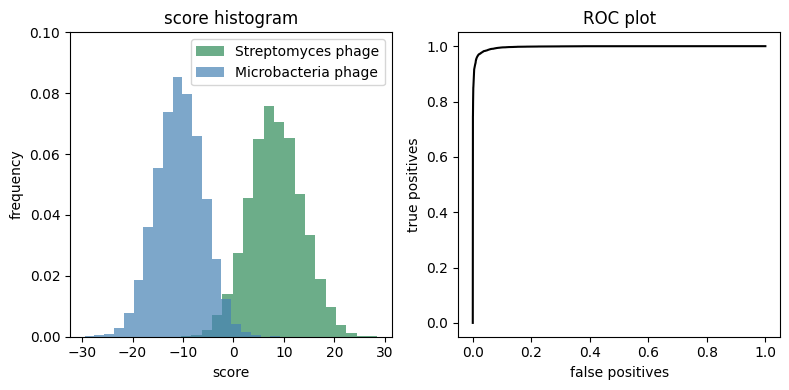

In [14]:
fig2, (ax3, ax4) = plt.subplots(1,2, figsize=(8,4))

ax3.hist(sc1_mine, bins=20, density=True, color='seagreen',  label='Streptomyces phage',   alpha=0.7)
ax3.hist(sc2_mine, bins=20, density=True, color='steelblue', label='Microbacteria phage',  alpha=0.7)
ax3.set_title('score histogram')
ax3.set_xlabel('score')
ax3.set_ylabel('frequency')
ax3.set_ylim([0, 0.10])
ax3.legend()

ax4.plot(roc_FP_mine, roc_TP_mine, 'k-')
ax4.set_title('ROC plot')
ax4.set_xlabel('false positives')
ax4.set_ylabel('true positives')

fig2.tight_layout()


Much better! There's still some overlap in those plots though. Is it something I need to worry about? (Yes, as we're about to see.)



## 3. how good is your method?

We want to find the score threshold that achieves 90% sensitivity. That means finding the 9001'th highest score (9000/10000 = 90% are greater than it). 

In [15]:
sc1_mine.sort(reverse=True)
print('Set the threshold to: {:.2f}'.format(sc1_mine[9000]))

Set the threshold to: 1.71


What's the false positive rate at that threshold? Count how many sc2's are above it. (Double check that our TPR is indeed 90% while we're at it.)

In [16]:
threshold = 1.71
TP_overall = sum(1 for x in sc1_mine if x > threshold) / len(sc1_mine)
FP_overall = sum(1 for x in sc2_mine if x > threshold) / len(sc2_mine)

print("Score threshold:  {0:.2f}".format(threshold))
print("True positive rate is then: {0:.4f}".format(TP_overall))
print("False positive rate is then: {0:.4f}".format(FP_overall))


Score threshold:  1.71
True positive rate is then: 0.9000
False positive rate is then: 0.0038


A false positive rate of 0.4% doesn't sound bad, right?

OK, but we were told that in a sample, 0.1% of the reads are from _Streptomyces_ phage, and 99.9% are from _Microbacterium_ phage. A false positive rate of 0.4% means that 0.4% of _Microbacterium_ phage reads will be called positive: as a fraction of the total reads in a sample, that's $0.004 \cdot 0.999$. Our sensitivity of 90% means that 90% of _Streptomyces_ phage reads will be classified as positive: as a fraction of the total reads of the sample, that's $0.90 \cdot 0.001$. We're going to be calling about four times more false positives than true positives! The _false discovery rate_ is the proportion of things that meet our threshold that are actually wrong false positives. That's:

In [17]:
frac_strep = 0.001
frac_micro = 0.999

tot_positive = (TP_overall * frac_strep) + (FP_overall * frac_micro) 

FDR = (FP_overall * frac_micro) / tot_positive
print('FDR is: {0:.3f}'.format(FDR))

FDR is: 0.808


Despite how good that ROC plot looked, and despite the fact that we have only a 0.4% false positive rate, **80% of our predictions will be wrong**. 

The lesson: when you're looking for needles in haystacks, where there are few positives and many negatives, you need very low false positive rates. When someone shows you a ROC plot for such a problem, be wary. All the relevant action might be in the leftmost invisible sliver of the plot. In typical genome-wide data analysis, a method that gives a false positive rate of 10% or 1% can be truely terrible.

In [18]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,jupyter

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

numpy     : 2.1.0
matplotlib: 3.9.2
jupyter   : 1.0.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

